In [1]:
from pathlib import Path
import torch
import argparse
import os
import cv2
import numpy as np
import sys
import json
from typing import Dict, Optional

from wilor.models import WiLoR, load_wilor
from wilor.utils import recursive_to
from wilor.datasets.vitdet_dataset import ViTDetDataset, DEFAULT_MEAN, DEFAULT_STD
from wilor.utils.renderer import Renderer, cam_crop_to_full
from ultralytics import YOLO 
import trimesh
import pyrender
import matplotlib.pyplot as plt
LIGHT_PURPLE=(0.25098039,  0.274117647,  0.65882353)

sys.path.append(os.path.abspath("/home/brianchen/brian/PressureVision"))

# import fpn as smp
from recording.util import load_config, find_latest_checkpoint, classes_to_scalar
from recording.sequence_reader import SequenceReader
from prediction.model_builder import build_model
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
from torchsummary import summary

In [2]:
def project_full_img(points, cam_trans, focal_length, img_res): 
    camera_center = [img_res[0] / 2., img_res[1] / 2.]
    K = torch.eye(3) 
    K[0,0] = focal_length
    K[1,1] = focal_length
    K[0,2] = camera_center[0]
    K[1,2] = camera_center[1]
    points = points + cam_trans
    points = points / points[..., -1:] 
    
    V_2d = (K @ points.T).T 
    return V_2d[..., :-1]

In [3]:
model, model_cfg = load_wilor(checkpoint_path = './pretrained_models/wilor_final.ckpt' , cfg_path= './pretrained_models/model_config.yaml')
detector = YOLO('./pretrained_models/detector.pt')
renderer = Renderer(model_cfg, faces=model.mano.faces)
renderer_side = Renderer(model_cfg, faces=model.mano.faces)

device   = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model    = model.to(device)
detector = detector.to(device)
model.eval()

Loading  ./pretrained_models/wilor_final.ckpt


/home/brianchen/.local/lib/python3.10/site-packages/ultralytics/nn/tasks.py:716: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")


WiLoR(
  (backbone): ViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16), padding=(2, 2))
    )
    (pose_emb): Linear(in_features=6, out_features=1280, bias=True)
    (shape_emb): Linear(in_features=10, out_features=1280, bias=True)
    (cam_emb): Linear(in_features=3, out_features=1280, bias=True)
    (decpose): Linear(in_features=1280, out_features=6, bias=True)
    (decshape): Linear(in_features=1280, out_features=10, bias=True)
    (deccam): Linear(in_features=1280, out_features=3, bias=True)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (

In [4]:
thumb = 4
index = 8
middle = 12
ring = 16
pinky = 20

In [5]:
finger_points = [4, 8, 12, 16, 20]

In [6]:
config = load_config("/home/brianchen/brian/PressureVision/config/paper")
config.TRAIN_FILTER = ["../PressureVision/data/train_fold_1/*/*"]
config.VAL_FILTER = ["../PressureVision/data/val_fold_5/*/*"]
config.CROP_IMAGES = False

In [7]:
model_dict = build_model(config, device, ['train','val'])

Loss function: CrossEntropyLoss()
Loading dataset with filter: ['../PressureVision/data/train_fold_1/*/*']. Skipping 1 frames
Done loading dataset. Total size: 104488
Loading dataset with filter: ['../PressureVision/data/val_fold_5/*/*']. Skipping 200 frames
Done loading dataset. Total size: 497


In [8]:
def create_finger_classes(force_arr, finger_points, img_shape=(1920, 1080), radius=50):

    finger_class = np.zeros(force_arr.shape)

    # points = np.array(joints_2d[finger_points])
    target_points = np.array(list(np.ndindex(img_shape)))

    differences = finger_points[np.newaxis, :, :] - target_points[:, np.newaxis, :]

    distances = np.linalg.norm(differences, axis=2)

    # closest_indices = np.argmin(distances, axis=1).reshape(temp.shape[:2])

    closest_indices = np.zeros(img_shape)

    bool_arr = (np.min(distances, axis=1) < radius).reshape(img_shape)

    closest_indices[bool_arr] = (np.argmin(distances, axis=1).reshape(img_shape)[bool_arr] + 1)/6

    finger_class[force_arr > 0] = closest_indices.T[force_arr > 0]  

    return finger_class

In [9]:
os.makedirs("finger_force_db", exist_ok=True)
os.makedirs("finger_force_db/original_img", exist_ok=True)
os.makedirs("finger_force_db/finger_force", exist_ok=True)
os.makedirs("finger_force_db/hand_mesh", exist_ok=True)

for i in tqdm(range(len(model_dict["train_dataset"]))):
        # if i > 50:
        #      break
        img_path = os.path.join(model_dict["train_dataset"][i]["seq_path"], f'camera_{model_dict["train_dataset"][i]["camera_idx"]}', f'{model_dict["train_dataset"][i]["timestep"]:05}.jpg')
        img_cv2 = cv2.imread(str(img_path))
        img_shape = img_cv2.shape[:2:-1]

        detections = detector(img_cv2, conf = 0.3, verbose=False)[0]
        bboxes    = []
        is_right  = []
        for det in detections: 
            Bbox = det.boxes.data.cpu().detach().squeeze().numpy()
            is_right.append(det.boxes.cls.cpu().detach().squeeze().item())
            bboxes.append(Bbox[:4].tolist())
        
        if len(bboxes) == 0:
            continue
        boxes = np.stack(bboxes)
        right = np.stack(is_right)
        dataset = ViTDetDataset(model_cfg, img_cv2, boxes, right, rescale_factor=2.0)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False, num_workers=0)

        all_verts = []
        all_cam_t = []
        all_right = []
        all_joints= []
        all_kpts  = []
        
        for batch in dataloader: 
            batch = recursive_to(batch, device)
    
            with torch.no_grad():
                out = model(batch) 
                
            multiplier    = (2*batch['right']-1)
            pred_cam      = out['pred_cam']
            pred_cam[:,1] = multiplier*pred_cam[:,1]
            box_center    = batch["box_center"].float()
            box_size      = batch["box_size"].float()
            img_size      = batch["img_size"].float()
            scaled_focal_length = model_cfg.EXTRA.FOCAL_LENGTH / model_cfg.MODEL.IMAGE_SIZE * img_size.max()
            pred_cam_t_full     = cam_crop_to_full(pred_cam, box_center, box_size, img_size, scaled_focal_length).detach().cpu().numpy()

            
            # Render the result
            batch_size = batch['img'].shape[0]
            for n in range(batch_size):
                # Get filename from path img_path
                # img_fn, _ = os.path.splitext(os.path.basename(img_path))
                
                verts  = out['pred_vertices'][n].detach().cpu().numpy()
                joints = out['pred_keypoints_3d'][n].detach().cpu().numpy()
                
                is_right    = batch['right'][n].cpu().numpy()
                verts[:,0]  = (2*is_right-1)*verts[:,0]
                joints[:,0] = (2*is_right-1)*joints[:,0]
                cam_t = pred_cam_t_full[n]
                kpts_2d = project_full_img(verts, cam_t, scaled_focal_length, img_size[n])
                joints_2d = project_full_img(joints, cam_t, scaled_focal_length, img_size[n])
                
                all_verts.append(verts)
                all_cam_t.append(cam_t)
                all_right.append(is_right)
                all_joints.append(joints)
                all_kpts.append(kpts_2d)
                
                # Save all meshes to disk
                camera_translation = cam_t.copy()
                tmesh = renderer.vertices_to_trimesh(verts, camera_translation, LIGHT_PURPLE, is_right=is_right)
                # tmesh.export(os.path.join("finger_force_db", f'{img_fn}_{n}.obj'))

                force_arr = model_dict["train_dataset"][i]["seq_reader"].get_force_pytorch(model_dict["train_dataset"][i]["camera_idx"], model_dict["train_dataset"][i]["timestep"], config)
                
                finger_classes = np.zeros((1080, 1920, 3)) * 255
                finger_classes[:, :, 0] = create_finger_classes(force_arr, np.array(joints_2d[finger_points]), radius=50)
                
                # temp[:, :, 0] = create_finger_classes(force_arr, np.array(joints_2d[finger_points]))

                # cv2.imwrite(os.path.join("finger_force_db/finger_force", f'force_{img_fn}.jpg'), finger_classes)
                np.save(os.path.join("finger_force_db/finger_force", f'force_{i}.jpg'), finger_classes)
                np.save(os.path.join("finger_force_db/finger_joints", f"{i}"), joints_2d[finger_points])

        # Render front view
        if len(all_verts) > 0:
            misc_args = dict(
                mesh_base_color=LIGHT_PURPLE,
                scene_bg_color=(1, 1, 1),
                focal_length=scaled_focal_length,
            )
            cam_view = renderer.render_rgba_multiple(all_verts, cam_t=all_cam_t, render_res=img_size[n], is_right=all_right, **misc_args)

            # Overlay image
            # input_img = img_cv2.astype(np.float32)[:,:,::-1]/255.0
            # input_img = np.concatenate([input_img, np.ones_like(input_img[:,:,:1])], axis=2) # Add alpha channel
            # input_img_overlay = input_img[:,:,:3] * (1-cam_view[:,:,3:]) + cam_view[:,:,:3] * cam_view[:,:,3:]
            # print(cam_view)
            # print(255*cam_view[:, :, ::-1])
            cv2.imwrite(os.path.join("finger_force_db/original_img", f'{i}.jpg'), img_cv2)
            cv2.imwrite(os.path.join("finger_force_db/hand_mesh", f'{i}.jpg'), 255*cam_view[:, :, ::-1])

  0%|          | 5/104488 [00:01<5:56:31,  4.88it/s] /home/brianchen/brian/WiLoR/wilor/utils/geometry.py:61: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  b3 = torch.cross(b1, b2)
  3%|▎         | 2793/104488 [1:13:48<58:41:16,  2.08s/it] 

In [68]:
cv2.imread("/home/brianchen/brian/WiLoR/finger_force_db/finger_force/force_10.jpg").sum()

0

In [17]:
force_arr = model_dict["train_dataset"][84]["seq_reader"].get_force_pytorch(model_dict["train_dataset"][84]["camera_idx"], model_dict["train_dataset"][84]["timestep"], config)

In [18]:
force_arr.sum()

0.0

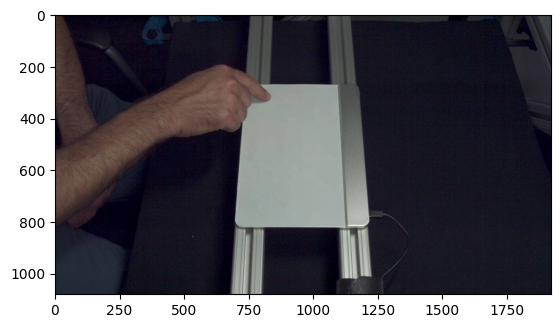

In [24]:
plt.imshow(model_dict["train_dataset"][17]["img_original"].transpose((1,2,0)))

In [39]:
create_finger_classes(force_arr, np.array(joints_2d[finger_points])).shape

(1080, 1920)

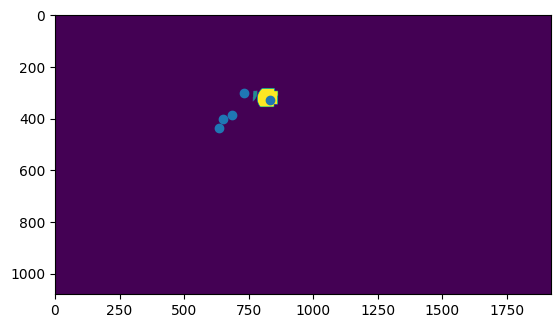

In [34]:
plt.scatter(joints_2d[finger_points, 0], joints_2d[finger_points, 1])
plt.imshow(create_finger_classes(force_arr, np.array(joints_2d[finger_points])))

In [12]:
def img_to_params(dataset, i):
    img_path = os.path.join(dataset[i]["seq_path"], f'camera_{dataset[i]["camera_idx"]}', f'{dataset[i]["timestep"]:05}.jpg')
    img_cv2 = cv2.imread(str(img_path))
    # img_shape = img_cv2.shape[:2:-1]

    detections = detector(img_cv2, conf = 0.3, verbose=False)[0]
    bboxes    = []
    is_right  = []
    for det in detections: 
        Bbox = det.boxes.data.cpu().detach().squeeze().numpy()
        is_right.append(det.boxes.cls.cpu().detach().squeeze().item())
        bboxes.append(Bbox[:4].tolist())
    
    if len(bboxes) == 0:
        return img_path

    boxes = np.stack(bboxes)
    right = np.stack(is_right)
    dataset = ViTDetDataset(model_cfg, img_cv2, boxes, right, rescale_factor=2.0)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False, num_workers=0)

    all_verts = []
    all_cam_t = []
    all_right = []
    all_joints= []
    all_kpts  = []
        
    for batch in dataloader: 
        batch = recursive_to(batch, device)

        with torch.no_grad():
            out = model(batch) 
            
        multiplier    = (2*batch['right']-1)
        pred_cam      = out['pred_cam']
        pred_cam[:,1] = multiplier*pred_cam[:,1]
        box_center    = batch["box_center"].float()
        box_size      = batch["box_size"].float()
        img_size      = batch["img_size"].float()
        scaled_focal_length = model_cfg.EXTRA.FOCAL_LENGTH / model_cfg.MODEL.IMAGE_SIZE * img_size.max()
        pred_cam_t_full     = cam_crop_to_full(pred_cam, box_center, box_size, img_size, scaled_focal_length).detach().cpu().numpy()
        
        # Render the result
        batch_size = batch['img'].shape[0]
        for n in range(batch_size):
            # Get filename from path img_path
            img_fn, _ = os.path.splitext(os.path.basename(img_path))
        
            verts  = out['pred_vertices'][n].detach().cpu().numpy()
            joints = out['pred_keypoints_3d'][n].detach().cpu().numpy()
            
            is_right    = batch['right'][n].cpu().numpy()
            verts[:,0]  = (2*is_right-1)*verts[:,0]
            joints[:,0] = (2*is_right-1)*joints[:,0]
            cam_t = pred_cam_t_full[n]
            kpts_2d = project_full_img(verts, cam_t, scaled_focal_length, img_size[n])
            joints_2d = project_full_img(joints, cam_t, scaled_focal_length, img_size[n])
                
            all_verts.append(verts)
            all_cam_t.append(cam_t)
            all_right.append(is_right)
            all_joints.append(joints)
            all_kpts.append(kpts_2d)
                
            # Save all meshes to disk
            camera_translation = cam_t.copy()
            tmesh = renderer.vertices_to_trimesh(verts, camera_translation, LIGHT_PURPLE, is_right=is_right)
            tmesh.export(os.path.join("finger_force_db", f'{img_fn}_{n}.obj'))

            force_arr = model_dict["train_dataset"][i]["seq_reader"].get_force_pytorch(model_dict["train_dataset"][i]["camera_idx"], model_dict["train_dataset"][i]["timestep"], config)
            
            finger_classes = np.zeros((1080, 1920, 3)) * 255
            finger_classes[:, :, 0] = create_finger_classes(force_arr, np.array(joints_2d[finger_points]), radius=50)

        # Render front view
    if len(all_verts) > 0:
        misc_args = dict(
            mesh_base_color=LIGHT_PURPLE,
            scene_bg_color=(1, 1, 1),
            focal_length=scaled_focal_length,
        )
        cam_view = renderer.render_rgba_multiple(all_verts, cam_t=all_cam_t, render_res=img_size[n], is_right=all_right, **misc_args)

    return cam_view, finger_classes, force_arr, joints_2d

No hand detected: 0
No hand detected: 1
No hand detected: 2
No hand detected: 3
No hand detected: 4
No hand detected: 5
No hand detected: 6
Finger Force Wrong: 13
No hand detected: 14
No hand detected: 15
No hand detected: 16
No hand detected: 17
No hand detected: 18
No hand detected: 19
Finger Force Wrong: 26
No hand detected: 27
No hand detected: 28
No hand detected: 29
No hand detected: 30
No hand detected: 31
No hand detected: 32
No hand detected: 40
No hand detected: 41
No hand detected: 42
No hand detected: 43
No hand detected: 44
No hand detected: 45
Finger Force Wrong: 54
Finger Force Wrong: 55
No hand detected: 56
No hand detected: 57
No hand detected: 58
No hand detected: 59
No hand detected: 60
Finger Force Wrong: 68
Finger Force Wrong: 69
No hand detected: 70
No hand detected: 71
No hand detected: 72
No hand detected: 73
No hand detected: 74
No hand detected: 75
No hand detected: 76
No hand detected: 77
No hand detected: 78
No hand detected: 79
No hand detected: 80
No hand 

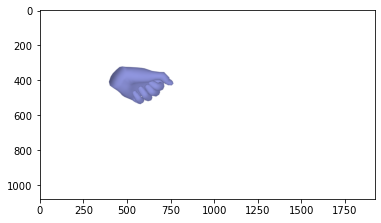

In [37]:
for i in range(100):

    return_obj = img_to_params(model_dict["train_dataset"], i)

    if not isinstance(return_obj, str):
        plt.imshow(return_obj[0])

        if return_obj[2].sum() > 0 and return_obj[1].sum() == 0:
            print(f"Finger Force Wrong: {i}")
    else:
        plt.imshow(cv2.imread(return_obj))
        print(f"No hand detected: {i}")

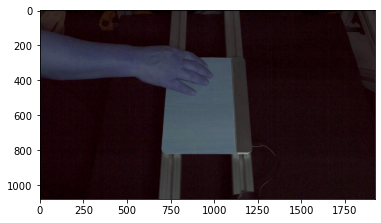

In [69]:
i = 10
return_obj = img_to_params(model_dict["train_dataset"], i)
plt.imshow(cv2.imread(os.path.join(model_dict["train_dataset"][i]["seq_path"], f'camera_{model_dict["train_dataset"][i]["camera_idx"]}', f'{model_dict["train_dataset"][i]["timestep"]:05}.jpg')))

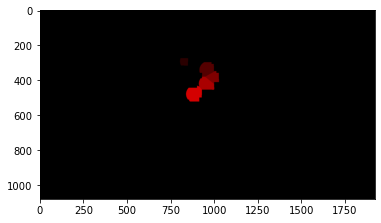

In [70]:
plt.imshow(return_obj[1])

In [71]:
cv2.imwrite("test.jpg", return_obj[1])

True

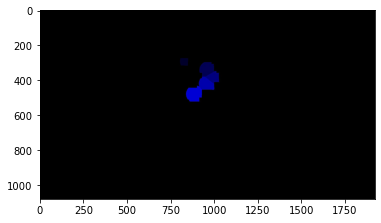

In [84]:
plt.imshow(cv2.imread("test.jpg"))

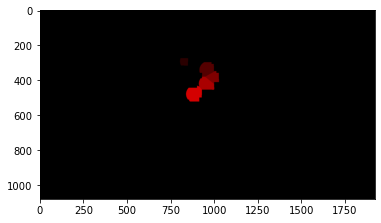

In [83]:
plt.imshow(return_obj[1])

In [75]:
plt.imsave("test.jpg", return_obj[1])

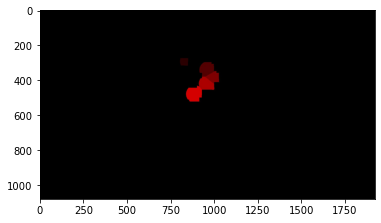

In [82]:
plt.imshow(plt.imread("test.jpg"))

In [92]:
arr = plt.imread("test.jpg")

In [93]:
arr.nonzero()

(array([271, 271, 271, ..., 528, 528, 528]),
 array([800, 801, 802, ..., 923, 926, 927]),
 array([2, 2, 2, ..., 1, 2, 2]))

In [97]:
arr[arr == 203]

array([203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203], dtype=uint8)

In [96]:
np.unique(arr)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 191, 192, 193, 19

In [100]:
np.unique(return_obj[1])

array([          0,     0.16667,     0.33333,         0.5,     0.66667,     0.83333])

In [101]:
np.save("test.jpg", return_obj[1])